### Some theory for SSD and anchor boxes
In, SSD we want to make detections at various scales, we want to detect large objects small objects and everything in-between. So we add layers to generate a stack of feature maps with a variety of sizes. These feature maps will be used to make detections.

The SSD paper explains that these feature maps will have different receptive field sizes, the anchor boxes we will generate don’t need to exactly corresond to the actual receptive fields. The paper presents a method to generate anchor “boxes so that specific feature maps learn to be responsive to particular scales of the objects.”

Generating these anchorboxes is relatively straightforward. The SSD paper presents a simple way to generate the anchorboxes using the following equation:

![Anchor scales](../readme_media/anchor_scales.png)

where :
- smin = 0.1
- smax = 0.9 
- k is the feature map number 
- m is the total number of feature maps in the model (for Mobilenetv2 backbone is 6)


Where the anchor box center is defined as :

![Anchor center](../readme_media/anchor_center.png)


For the MobilenetV2SSD (with 300,300 input size) the feature map sizes **f<sub>k</sub>** are: (19,10,5,3,2,1)


Generally, deeper feature layers tend to detect larger objects while shallow layers tend to do better with
smaller objects.


**Source**: https://usmanr149.github.io/urmlblog/computer%20vision/2022/09/09/SSD-Anchorboxes.html


In [ ]:
# Generate anchors, ignoring the aspect ratios (for now)

anchor_boxes = []
feature_maps = [28, 14, 7, 4, 2, 1]
s_min = 0.1
s_max = 1.5
m = len(feature_maps)  # Number of feature maps

# Iterate through each feature map
for k, f_k in enumerate(feature_maps):
    s_k = s_min + (s_max - s_min) * k / (m - 1)  # Calculate scale for current feature map
    for i in range(f_k):  # Loop over rows
        for j in range(f_k):  # Loop over columns
            cx = (i + 0.5) / float(f_k)  # Center x
            cy = (j + 0.5) / float(f_k)  # Center y
            anchor_boxes.append([cx, cy, s_k, s_k])

# Total number of anchor boxes generated
total_anchors = len(anchor_boxes)
print(f"Total anchors generated: {total_anchors}")

# More theory...

This is not all though, as we can also add more anchor boxes by varying the aspect ratios. 
The SSD paper recommends using 5 aspect ratios denoted as (1,2,3,0.5,0.33).


The width and height for each aspect ratio is altered by the following equations:

![Anchor equations](../readme_media/aspect_ratio_dims.png)

For the aspect ratio of 1, an additional default box is also added with scale:
s'_k = sqrt(s_k * s_{k+1})

This means that 6 default anchor boxes are generated per feature map location for the default model from the paper.


# Calculate anchors for multiple aspect ratios

In [1]:
import math

anchor_boxes = []
feature_maps = [28, 14, 7, 4, 2, 1]
aspect_ratios = [1,0.8, 1.2, 1.4]
s_min = 0.1
s_max = 1.5
m = len(feature_maps)

# Pre-calculate the scales
scales = [s_min + (s_max - s_min) * ((k - 1) / (m - 1)) for k in range(1, m + 1)]

# Iterate through each feature map
for k, f_k in enumerate(feature_maps):
    s_k = scales[k]  # Get the scale for the current feature map
    print(f'Scale for feature map {k} (size {f_k}): {s_k}')
    
    if k < len(feature_maps) - 1:
        s_next = scales[k + 1]  # Scale for the next feature map
        s_prime_k = math.sqrt(s_k * s_next)  # Additional scale for aspect ratio 1
    else:
        s_prime_k = s_k  # Use the current scale for the last feature map
    
    for i in range(f_k):  # Loop over rows in feature map
        for j in range(f_k):  # Loop over columns in feature map
            cx = (i + 0.5) / float(f_k)
            cy = (j + 0.5) / float(f_k)
            
            # Generate anchor boxes for each aspect ratio
            for ar in aspect_ratios:
                if ar == 1:
                    anchor_boxes.append([cx, cy, s_k, s_k])  # Square box for aspect ratio 1
                    if s_prime_k is not None:
                        anchor_boxes.append([cx, cy, s_prime_k, s_prime_k])  # Additional box for aspect ratio 1 with s'_k
                else:
                    width = s_k * math.sqrt(ar)
                    height = s_k / math.sqrt(ar)
                    anchor_boxes.append([cx, cy, width, height])

# Total number of anchor boxes generated
total_anchors = len(anchor_boxes)
print(f"Total anchors generated: {total_anchors}")

# Debugging: Verify calculations for specific feature maps
for idx, f_k in enumerate(feature_maps):
    print(f"Feature Map Size: {f_k}, Anchors: {f_k * f_k * len(aspect_ratios)}")

Scale for feature map 0 (size 28): 0.1
Scale for feature map 1 (size 14): 0.38
Scale for feature map 2 (size 7): 0.6599999999999999
Scale for feature map 3 (size 4): 0.94
Scale for feature map 4 (size 2): 1.22
Scale for feature map 5 (size 1): 1.5
Total anchors generated: 5250
Feature Map Size: 28, Anchors: 3136
Feature Map Size: 14, Anchors: 784
Feature Map Size: 7, Anchors: 196
Feature Map Size: 4, Anchors: 64
Feature Map Size: 2, Anchors: 16
Feature Map Size: 1, Anchors: 4


# Save our anchors (cx,cy,w,h format) to a file

In [2]:
with open('anchors.txt', 'w') as file:
    for box in anchor_boxes:
        # Convert each box to a string and write it to the file
        file.write(f"{box[0]:.4f} {box[1]:.4f} {box[2]:.4f} {box[3]:.4f}\n")

# Some random anchor boxes visualized

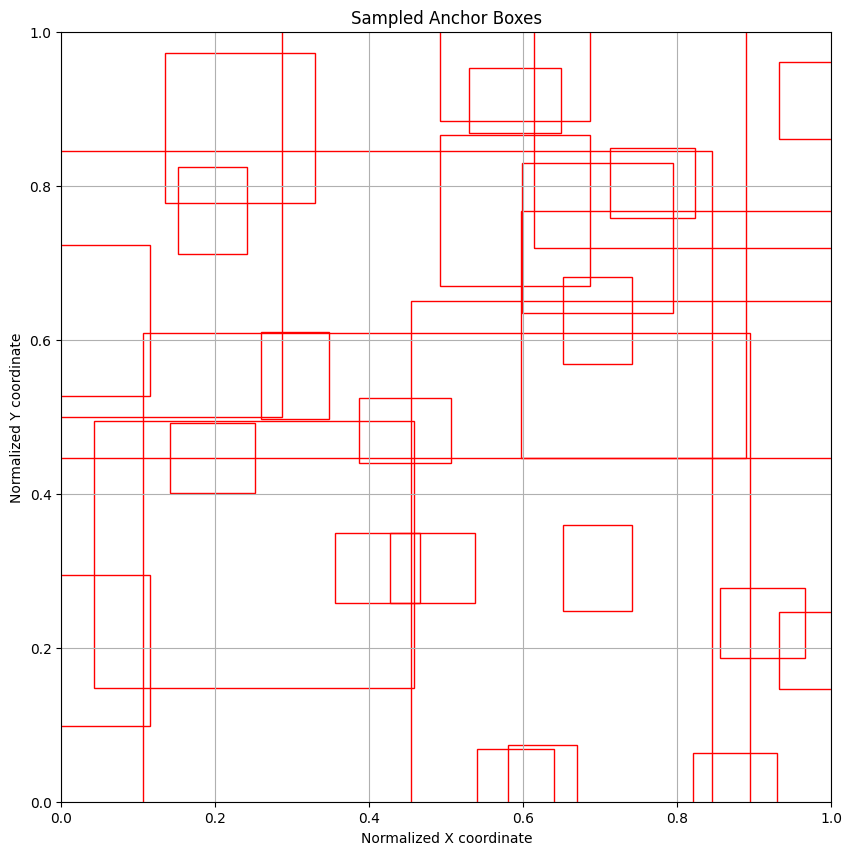

In [3]:
import random 
import matplotlib.pyplot as plt

# Randomly sample 30 anchor boxes
sampled_boxes = random.sample(anchor_boxes, 30)

# Plotting the anchor boxes
plt.figure(figsize=(10, 10))

# Plot each sampled anchor box
for box in sampled_boxes:
    cx, cy, width, height = box
    # Draw rectangle: converting center (cx, cy) and width/height to matplotlib rectangle
    rect = plt.Rectangle(
        (cx - width / 2, cy - height / 2),
        width,
        height,
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    )
    plt.gca().add_patch(rect)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Sampled Anchor Boxes')
plt.xlabel('Normalized X coordinate')
plt.ylabel('Normalized Y coordinate')
plt.grid(True)
plt.show()